# Applying Coordinate Transformations to Facilitate Data Comparison

## Applying ITRF and Plate Movement Models to Lidar Data from Pre-IceBridge, ICESat/GLAS, IceBridge, and ICESat-2 Data Sets

Comparing measurements across altimetry data sets where latitude, longitude, and surface heights have been collected over long periods of time – a span of 25+ year in the case of ICESat/GLAS, IceBridge and ICESat-2 – requires us to account for evolving coordinate reference systems and tectonic plate movement. To demonstrate why plate movement matters over time, let’s look at the Australian plate. It is moving at a rate of around 7 cm / year, so over 25 years the continent will have moved nearly 1.8 m. All of Earth’s land masses are affected by plate movement to varying degrees, and over a multi-decade time series it’s important to recognize that the position recorded for a location in 1993 is going to be different from what would be recorded at that same location today. Plate movement and updates to coordinate reference systems over time must be accounted for when analyzing data over long time periods to avoid drawing spurious conclusions from the data.

## Important Terms and Concepts

* Coordinate system: The 2-dimensional (latitude, longitude) or 3-dimensional (latitude, longitude, height) system, and unit of measure used to define where a point is located in space.
* Datum: A modeled version of the shape of the Earth which defines the origin used to place the coordinate system in space.
* Coordinate Reference System (CRS): A CRS comprises a coordinate system and a datum.
* Epoch (datum epoch): An epoch is used to identify the date at which a given reference frame was realized. They are also used to date when the coordinates for a particular observation (e.g., lat, lon, elevation) were obtained. Epochs are noted in decimal year format (YYYY.DD) where numbers to the right of the decimal are derived from the Julian day-in-year. The decimal year is equal to: year + day-in-year/365 (or 366 for leap years). For example, 1 January 2010 is written as 2010.00; 5 May 1991 is the 128th Julian day-in-year and written as 1991.35. To determine what month and day is represented by, say, 2018.5, multiply the numbers to the right of the decimal by the total number of days in 2018 (.5 * 365) to determine the Julian day-in-year is 183 (after rounding up to a whole number). Referencing a Julian date calendar (e.g., [here](https://www.timeanddate.com/calendar/custom.html?year=2020&country=1&doy=1&df=1) ) we see that 2018.5 corresponds to 2 July 2018.
* International Terrestrial Reference Frame (ITRF): A realization (i.e., a major adjustment) of the International Terrestrial Reference System (ITRS). Its origin is at the center of mass of the whole earth including the oceans and atmosphere. New ITRF solutions are produced every few years as the Earth changes and to employ the latest mathematical and surveying techniques to attempt to realize the ITRS as precisely as possible. Examples include ITRF88, ITRF93, ITRF2000, etc., with ITRF2014 being the latest realization of the ITRS. The ITRS is a formal description of the coordinate reference system, along with the mathematical and experimental procedures used to create reference frames and is maintained by the International Earth Rotation Service (IERS). The IERS issues parameters for transforming to and from older ITRF realizations. This makes it convenient to compare locations at any point on the Earth, but only for the same time, or epoch. Comparing coordinates in a dynamic frame from different epochs presents problems since the geographic features are being moved by plate tectonics, resulting in different coordinates for the same feature.

## Example Data Set

For the remainder of the notebook, we will use a fictitious data set comprising latitude, longitude, and elevation coordinates. We will illustrate the use of *PROJ* and *PyProj* libraries to perform transformations between CRSs, and coordinate propagation (the shift in coordinates for a given geographic feature as a result of tectonic plate movement) between epochs in the same CRS using a Plate Motion Model. We construct a set of coordinates roughly on the Greenland ice sheet, with fictitious elevations. The particular values are used to illustrate the effects of coordinate transformation and propagation.

In [1]:
from __future__ import annotations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer

In [2]:
# We're going to illustrate an example of fictitious data from 1993 being transformed to be comparable to data from 2018.
epoch1 = 1993.5
itrf1 = "ITRF93"
epoch2 = 2018.5
itrf2 = "ITRF2014"

# Create lats and lons evenly spaced 1x1m grid (1 cm spacing) anchored to a point on the Greenland icesheet.
lat0 = 70.0
lon0 = -50.0
lat_deg_m = 1 / 111000.0  # (~degrees / m)
lon_deg_m = 1 / 34300.0  # (~degrees / m)
delta_lat = lat_deg_m * 0.01  # 1 cm
delta_lon = lon_deg_m * 0.01  # 1 cm
num_points = 11
lats = lat0 + np.arange(num_points) * delta_lat
lons = lon0 + np.arange(num_points) * delta_lon
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Create elevations for illustration of coordinate transformation and propagation effects. The resulting "surface" will just be plane at constant elevation.
elev_grid = np.ones(lon_grid.shape)

# We set the observation epoch of the points of our sample data set.
epoch_grid = epoch1 * np.ones(lon_grid.shape)

Here we show a 10 x 10 grid spaced at 1 cm intervals, and set the elevations of each point at 1 m. The absolute latitude longitude values are at 70 N, 50 W, a spot "on" the Greenland ice sheet. We use this grid of points as our fictitious data set that we are going to transform using two methods. In the examples that follow, we're going to assume this data was collected in 1993 and we'd like to compare it to data collected in 2018. The fictitious data set which we will transform will be in the ITRF93 reference frame, and assume the 2018 data we'd like to compare it to is in the ITRF2014 frame.

Note the scale difference on the z-axis. All axes units are meters.

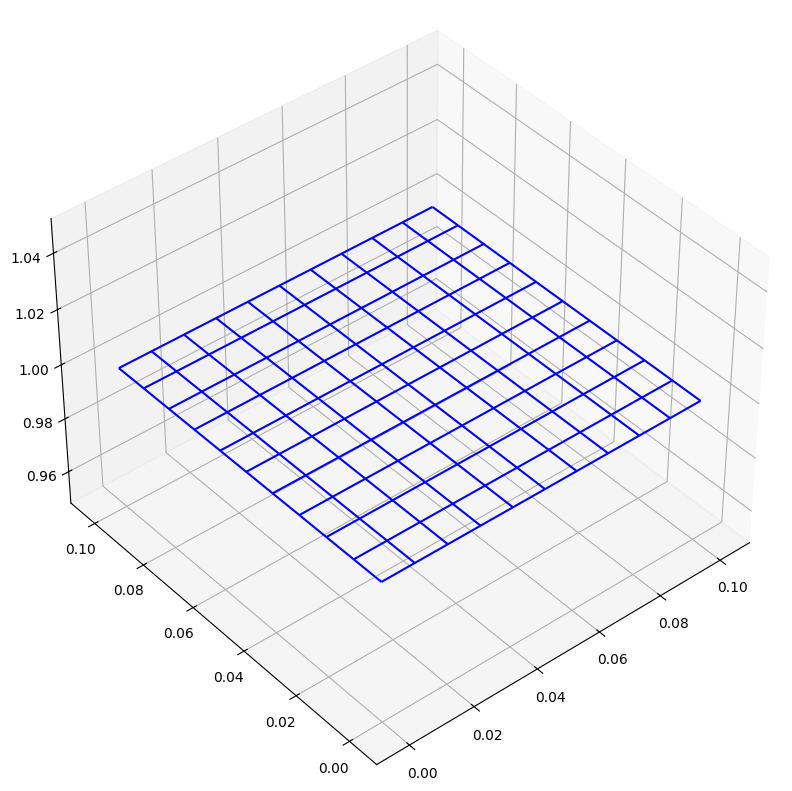

In [3]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(40, 230)
ax.set_xlim(-0.01, 0.11)
ax.set_ylim(-0.01, 0.11)

ax.plot_wireframe(
    (lon_grid - lon0) / lon_deg_m,
    (lat_grid - lat0) / lat_deg_m,
    elev_grid,
    color="blue",
)

## Coordinate Transformations between Reference Systems

As stated above, we'd like to transform the data collected in 1993 in the ITRF93 reference frame to allow comparison with points in the ITRF2014 frame. To do so, we create a *PROJ* pipeline that consists of a series of steps:

* Declare that all the ellipsoids we're dealing with are WGS84
* Convert from degrees to radians
* Convert from lat/lon/elevations to Cartesian coordinates
* Convert from the ITRF93 frame to ITRF2014
* Convert back to latitude / longitude coordinates
* Convert from radians to degrees

In [4]:
def create_transformer(from_crs, to_crs, to_epoch=None):
    plate_model_step = ""
    if to_epoch:
        plate_model_step = f"+step +inv +init={to_crs}:NOAM +t_epoch={to_epoch} "

    pipeline = (
        f"+proj=pipeline +ellps=WGS84 "
        f"+step +proj=unitconvert +xy_in=deg +xy_out=rad "
        f"+step +proj=latlon "
        f"+step +proj=cart "
        f"+step +inv +init={to_crs}:{from_crs} "
        + plate_model_step
        + "+step +proj=cart +inv "
        "+step +proj=unitconvert +xy_in=rad +xy_out=deg"
    )
    return Transformer.from_pipeline(pipeline)

We now calculate the magnitude of the coordinate shifts from ITRF93 to ITRF2014, and then plot the original grid (blue) and the newly shifted grid (green).

In [5]:
t = create_transformer(itrf1, itrf2)

(lons_2014, lats_2014, elevs_2014, epochs_2014) = t.transform(
    lon_grid.T.flatten(),
    lat_grid.T.flatten(),
    elev_grid,
    epoch1 * np.ones(lon_grid.shape),
)

max_lon_delta = np.max(abs(lons_2014 - lon_grid.T.flatten()))
print(f"Longitude delta (m): {max_lon_delta / lon_deg_m:0.3f}")
max_lat_delta = np.max(abs(lats_2014 - lat_grid.T.flatten()))
print(f"Latitude delta (m): {max_lat_delta / lat_deg_m:0.3f}")
max_elev_delta = np.max(abs(elevs_2014 - elev_grid))
print(f"Elevation delta (m): {max_elev_delta:0.3f}")

lons_2014 = np.reshape(lons_2014, (num_points, num_points))
lats_2014 = np.reshape(lats_2014, (num_points, num_points))

Longitude delta (m): 0.005
Latitude delta (m): 0.028
Elevation delta (m): 0.005


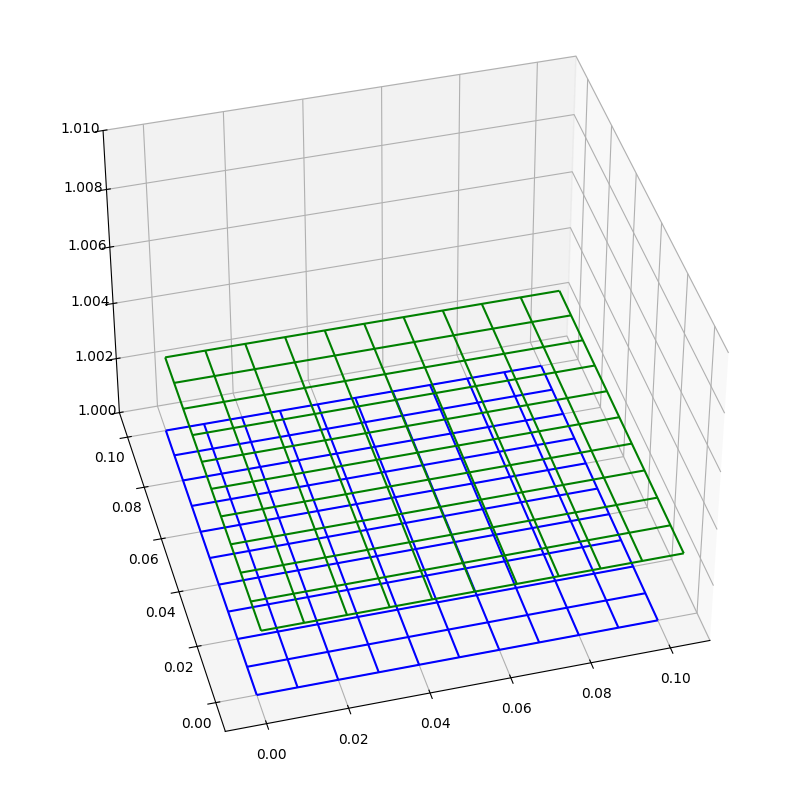

In [6]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(40, 255)
ax.set_xlim(-0.01, 0.11)
ax.set_ylim(-0.01, 0.11)
ax.set_zlim(1, 1.01)

ax.plot_wireframe(
    (lon_grid - lon0) / lon_deg_m,
    (lat_grid - lat0) / lat_deg_m,
    elev_grid,
    color="blue",
)
ax.plot_wireframe(
    (lons_2014 - lon0) / lon_deg_m,
    (lats_2014 - lat0) / lat_deg_m,
    elevs_2014,
    color="green",
)

## Coordinate Propagation between Epochs within One Coordinate Reference System

Now that our example data set is in the same reference frame as the data with which we'd like to compare it, we'd like to account for the shift in coordinates for a given geographic feature as a result of tectonic plate movement. To do so, we can make use of the ITRF2014 Plate Motion Model (PMM) and apply both the ITRF93 => ITRF2014 coordinate transformation _*and*_ the epoch 1993.5 => 2018.5 shift using the ITRFs PMM model parameters. 

Here we show the original data set (blue), the data set with only the ITRF93 => ITRF2014 transformation applied (green), and the data set obtained by applying the PMM coordinate propagation from 1993.5 through 2018.5 in five-year increments (red). We see that the ITRF93 => ITRF2014 shift applied a relatively small vertical and horizontal shift, and the PMM results in a much larger shift roughly to the northwest. We see that the magnitude of this PMM shift is much more significant, and perhaps significant to the comparison of data between epochs.

In [7]:
def propagated_data(
    from_crs, to_crs, obs_epoch, to_epoch, lon_grid, lat_grid, elev_grid
):
    t = create_transformer(from_crs, to_crs, to_epoch)
    (lons_new, lats_new, elevs_new, epochs_new) = t.transform(
        lon_grid.T.flatten(),
        lat_grid.T.flatten(),
        elev_grid,
        obs_epoch * np.ones(lon_grid.shape),
    )
    lons_new = np.reshape(lons_new, (num_points, num_points))
    lats_new = np.reshape(lats_new, (num_points, num_points))

    return (lons_new, lats_new, elevs_new, epochs_new)

dict_keys([np.float64(1993.5), np.float64(1998.5), np.float64(2003.5), np.float64(2008.5), np.float64(2013.5), np.float64(2018.5)])


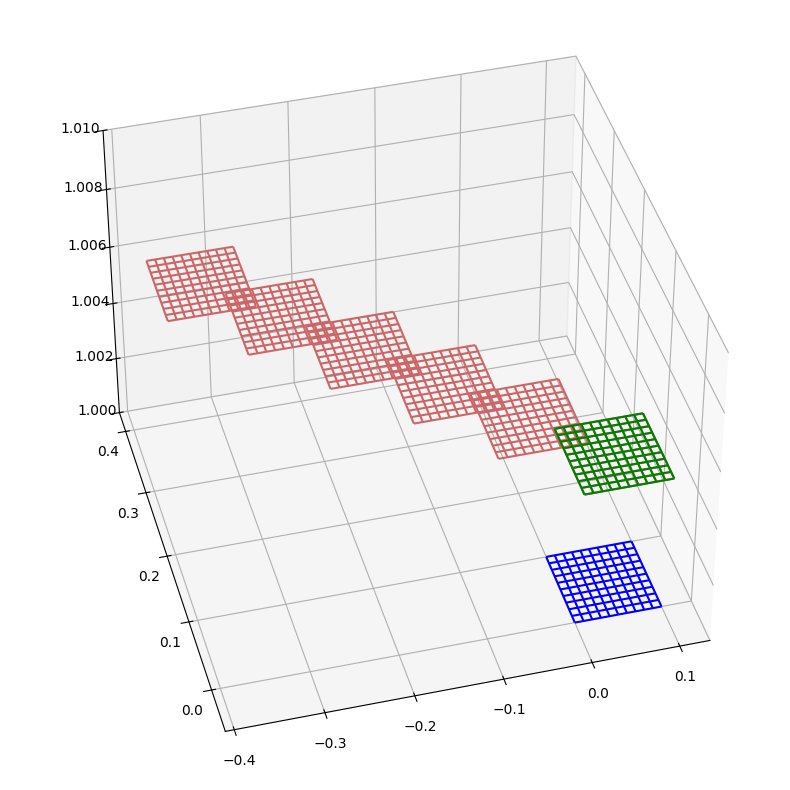

In [8]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(40, 255)
ax.set_zlim(1, 1.01)

ax.plot_wireframe(
    (lon_grid - lon0) / lon_deg_m,
    (lat_grid - lat0) / lat_deg_m,
    elev_grid,
    color="blue",
)

count = 6
propd_data = {
    y: propagated_data(itrf1, itrf2, epoch1, y, lon_grid, lat_grid, elev_grid)
    for y in np.linspace(epoch1, epoch2, count)
}
print(propd_data.keys())

for _y, (lons, lats, elevs, _) in propd_data.items():
    ax.plot_wireframe(
        (lons - lon0) / lon_deg_m,
        (lats - lat0) / lat_deg_m,
        elevs,
        color=mpl.colors.hsv_to_rgb([1, 0.5, 0.8]),
    )

ax.plot_wireframe(
    (lons_2014 - lon0) / lon_deg_m,
    (lats_2014 - lat0) / lat_deg_m,
    elevs_2014,
    color="green",
)

In [9]:
max_lon_delta = np.max(abs(propd_data[2018.5][0] - propd_data[1993.5][0]))
print(f"Longitude delta (m): {max_lon_delta / lon_deg_m:0.2f}")

max_lat_delta = np.max(abs(propd_data[2018.5][1] - propd_data[1993.5][1]))
print(f"Latitude delta (m): {max_lat_delta / lat_deg_m:0.2f}")

max_elev_delta = np.max(abs(propd_data[2018.5][2] - propd_data[1993.5][2]))
print(f"Elevation delta (m): {max_elev_delta:0.4f}")

Longitude delta (m): 0.37
Latitude delta (m): 0.33
Elevation delta (m): 0.0007


## References

### Overview of the Reference Frame and Plate Shift Problem
1. [The many paths to a common ground: A comparison of transformations between GDA94 and ITRF](https://www.spatial.nsw.gov.au/__data/assets/pdf_file/0003/165702/2011_Haasdyk_and_Janssen_IGNSS2011_comparison_of_GDA94-ITRF_transformations.pdf)
1. [GDA94, ITRF & WGS84Whatâ€™s the difference?](http://www.quickclose.com.au/stanaway07pres.pdf)
1. [Misaligned maps? High-accuracy data must become time-dependent](https://www.opengeospatial.org/blog/3045)
1. [Dynamic Datum Transformations in Australia and New Zealand](http://ceur-ws.org/Vol-1142/paper6.pdf)
1. [Making Sense of Evolving Datums:WGS84 and NAD83](http://www.naref.org/transf/nad83_hydroscan2006.pdf)
1. [Re: Dynamic/static WGS84 datum problem with web-mapping and map misalignment](http://osgeo-org.1560.x6.nabble.com/Re-Dynamic-static-WGS84-datum-problem-with-web-mapping-and-map-misalignment-td5412013.html)
1. [From static to dynamic datums: 150 years of geodetic datums in New Zealand](https://doi.org/10.1080/00288306.2015.1128451)
1. [The new world of Earth-fixed datums](https://www.spatialsource.com.au/company-industry/new-world-earth-fixed-datums)
1. [FIG/IAG/UN-GGIM-AP/UN-ICG/NZISTechnical Seminar Reference Frame in Practice](https://www.fig.net/resources/proceedings/2016/2016_05_reference%20frame/1_Rizos.pdf)

### ITRF
1. [ITRF](https://www.iers.org/IERS/EN/DataProducts/ITRF/itrf.html;jsessionid=04D3589399F3433E18FD3739F941D96A.live1)
1. [IERS CONVENTIONS (2003) / IERS Technical Note No. 32](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn32.html)
1. [IERS CONVENTIONS (2010) / IERS Technical Note No. 36](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn36.html)
1. [Analysis and results of ITRF2014 / IERS Technical Note No. 38](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn38.html)
1. [ITRF2008: an improved solution of the internationalterrestrial reference frame](https://doi.org/10.1007/s00190-011-0444-4)
1. [ITRF2008 plate motion model](https://doi.org/10.1029/2011JB008930)
1. [ITRF2014: A new release of the International Terrestrial Reference Frame modeling nonlinear station motions](https://doi.org/10.1002/2016JB013098)
1. [ITRF2014 plate motion model](https://doi.org/10.1093/gji/ggx136)

### GPS
1. [GPS Reference Systems](http://www.nbmg.unr.edu/staff/pdfs/Blewitt_Encyclopedia_of_Geodesy.html)
1. [GPS Geodetic Reference System  WGS 84](https://www.gps.gov/multimedia/presentations/2009/09/ICG/wiley.pdf)
1. [Reference Frames in Practice Manual. FIG Publication No. 64](http://www.fig.net/resources/publications/figpub/pub64/Figpub64.pdf)
1. [Data collection of WGS 84 information â€” or is it?](https://www.gpsworld.com/data-collection-of-wgs-84-information-or-is-it/)

### Libraries
1. [PROJ](https://proj.org/index.html)
1. [PyProj](https://pyproj4.github.io/pyproj/stable/index.html)
1. [GitHub: Add plate motion model parameters to ITRF init-files](https://github.com/OSGeo/PROJ/commit/403f930355926aced5caba5bfbcc230ad152cf86)
1. [[PROJ] Static/Dynamic Webmapping Problem version 2.0](https://lists.osgeo.org/pipermail/proj/2019-July/008703.html)
1. [[PROJ] Seeking clarification on PROJ support for temporal transformations](https://lists.osgeo.org/pipermail/proj/2019-August/008789.html)
1. [[PROJ] OGC blog post summarising Web-mapping misalignment problem](https://lists.osgeo.org/pipermail/proj/2019-August/008776.html)
1. [Re: [gdal-dev] Static/Dynamic datum problems](http://osgeo-org.1560.x6.nabble.com/Re-gdal-dev-Static-Dynamic-datum-problems-td5408589.html)

### Plate Motion
1. [UNAVCO Plate Motion Calculator](https://www.unavco.org/software/geodetic-utilities/plate-motion-calculator/plate-motion-calculator.html)